# STATISTICAL MACHINE LEARNING

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier

In [2]:
class Dataset(object):
    def __init__(self):
        raise notImplementedError()
    
    def __len__(self):
        raise notImplementedError()
    
    def __get_item__(self):
        raise notImplementedError()
    

In [3]:
class WrapperDataset(Dataset):
    def __init__(self,data):
        self.data = data
    def __len__(self):
        return len(self.data)
    def __get_item__(self,index):
        return self.data[index]

In [4]:
class Gaussian_Cond_Distr_Dataset(Dataset):
    def __init__(self,p_y,t_dim,mu_t, sigma_t, length_dataset,seed):
        ''' build a dataset with x distributed with gaussian conditional probability.
        Y is a dichotomous RV.
        T|Y is a RV distributed following a multinormal distribution.
        
        p_y: probability that Y = 1.
        t_dim: dimension of the RV T.
        mu_t: list with 2 elements: [mean(T|Y=0),mean(T|Y=1)]
        sigma_t: list of covariance Matrix: [cov(T|Y=0),cov(T|Y=1)]
        
        '''
        np.random.seed(seed)
        self.data = []
        for i in range(length_dataset):
            temp = np.random.random()
            if temp<p_y:
                y = 1
                if t_dim==1:
                    t = np.random.normal(loc = mu_t[1], scale = sigma_t[1])
                else:
                    t = np.random.multivariate_normal(mean= mu_t[1], cov = sigma_t[1])
                    
            else:
                y = 0
                if t_dim==1:
                    t = np.random.normal(loc = mu_t[0], scale = sigma_t[0])
                else:
                    t = np.random.multivariate_normal(mean= mu_t[0], cov = sigma_t[0])
                    
            self.data.append((t,y))
    def __len__(self):
        return len(self.data)
    
    def __get_item__(self, index):
        return self.data[index]
    
            
            

In [5]:
def plot2DDataset(dataset):
    '''plot a dataset: the red points are labelled with y=1, the blue ones with y=0'''
    plt.figure()
    for i in range(dataset.__len__()):
        x = dataset.__get_item__(i)
        if x[1]==1:
            plt.plot(*x[0],'r*')
        else:
            plt.plot(*x[0],'b.')
    plt.show()

In [6]:
? plt.plot

In [7]:
t_dim = 2
p_y = 0.5
mu_t = [[0,0],[5,5]]
sigma_t = [np.diag([1,1]), np.diag([1,1])]
length_dataset = 200
seed = 3
dataset = Gaussian_Cond_Distr_Dataset(p_y,t_dim,mu_t, sigma_t, length_dataset,seed)

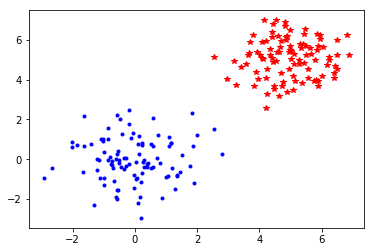

In [8]:
plot2DDataset(dataset)

In [40]:
class Bootstrap(object):
    def __init__(self, dataset, nb_bootstrap, seed=None):
        ''' create n bootstrap sample from a dataset.
        
        dataset: Dataset object
        
        nb_bootstrap: int number 
        
        seed: seed used for random number generation, if not given the seed
        will not be modified.
        '''
        self.dataset = dataset
        self.test_set = None
        self.models = None
        self.model_name = None
        self.model = None
        BOOError = np.nan
        if seed != None:
            np.random.seed(seed)
        
        # create bootstrap samples
        indexes = np.arange(self.dataset.__len__())
        self.list_of_bootstrap_dataset = []
        self.binary_matrix = np.ones((nb_bootstrap,self.dataset.__len__()))
        for i in range(nb_bootstrap):
            temp = np.random.choice(indexes, size = self.dataset.__len__(), replace = True)
            self.list_of_bootstrap_dataset.append(temp)
            self.binary_matrix[i,np.array(temp)] = 0
            
    def __len__(self):
        return len(self.list_of_bootstrap_dataset)
    
    def __get_element__(self, index_dataset, index):
        ''' get the (index)^th element from the (index_dataset)^th bootstrap dataset.'''
        
        return dataset.__get_item__(self.list_of_bootstrap_dataset[index_dataset][index])
    
    def __get_dataset__(self, index_dataset):
        data = [self.dataset.__get_item__(index) for index in self.list_of_bootstrap_dataset[index_dataset]]
        data = WrapperDataset(data)
        
        return data
    def train_models(self, model_name):
        nb_models = self.__len__()
        self.model_name = model_name
        self.models = []
        for i in range(nb_models):
            model = model_name(self.__get_dataset__(i))
            model.__train__()
            self.models.append(model)
        
        self.model=model_name(self.dataset)
        self.model.__train__()
        

    def compute_OOBerror(self):
        nb_models = self.__len__()
        errors = []
        if self.models == None:
            print('Error the models were not defined')
            return 0
        
        for j in range(self.dataset.__len__()):
            if self.binary_matrix[:,j].sum()>0:
                temp = np.where(self.binary_matrix[:,j])[0]
                error = 0
                x,y = self.dataset.__get_item__(j)
                
                for k in temp:
                    model = self.models[k]
                    prediction = model.__predict__([x])
                    error+= 1*(prediction[0] != y)
                errors.append(error/self.binary_matrix[:,j].sum())
        
        BOOError = np.mean(errors)
        
        return BOOError
    def predict_models(self, x):
        predictions = [model.__predict__(x) for model in self.models]
        predictions = 1*(np.mean(predictions) > 0.5)
        return predictions
        
    def compute_train_error(self):
        '''compute the train error on the entire dataset for a given model'''
        n = self.dataset.__len__()
        model = self.model_name(self.dataset)
        model.__train__()
        train_error = 0
        for i in range(n):
            data,label = self.dataset.__get_item__(i)
            prediction = model.__predict__([data])
            train_error += 1*(prediction[0]!=label)
        train_error = train_error/n
        return train_error
    def compute_test_error(self):
        n = self.test_set.__len__()
        model = self.model_name(self.dataset)
        model.__train__()
        train_error = 0
        for i in range(n):
            data,label = self.test_set.__get_item__(i)
            prediction = model.__predict__([data])
            train_error += 1*(prediction[0]!=label)
        train_error = train_error/n
        return train_error
    
    def compute_632_error(self):
        error = 0.368*self.compute_train_error() + 0.632* self.compute_OOBerror()
        return error
     
    def compute_632_error_plus(self):
        n = self.dataset.__len__()
        gamma = 0
        
        for i in range(n):
            data_i,label_i = self.dataset.__get_item__(i)
            pred_i = self.model.__predict__([data_i])
            
            for j in range(i+1):
                data_j, label_j = self.dataset.__get_item__(j)
                pred_j = self.model.__predict__([data_j])
                if i!=j:
                    gamma += (1*(pred_i[0]!=label_j)) + (1*(pred_j[0]!=label_i))
                else:
                    gamma += (1*(pred_i[0]!=label_j))
                
        gamma = gamma/n**2
        print(gamma)
        error_OOB= self.compute_OOBerror()
        error_train = self.compute_train_error()
        if error_OOB> error_train and gamma>error_train:
            R = (error_OOB-error_train)/(gamma-error_train)
        else :
            R = 0
        error_OOB_mod = np.min([error_OOB,gamma])
        
        error_632 = (0.632 * error_OOB + 0.368 * error_train)
        correction = (error_OOB_mod-error_train)*(0.368*0.632*R)/(1-0.368*R)
        
        error_632_plus = error_632 + correction
            
        return error_632_plus
        

In [10]:
class Model(object):
    def __init__(self):
        raise notImplementedError()
    def __train__(self):
        raise notImplementedError()
    def __predict__(self):
        raise notImplementedError()
    def __get_train_error__(self):
        raise notImplementedError()

In [11]:
class LDAModel(Model):
    def __init__(self,dataset):
        self.dataset = dataset
        self.model = LinearDiscriminantAnalysis()
        self.train_error = np.nan
    def __train__(self):
        data=[]
        label=[]
        for i in range(self.dataset.__len__()):
            x,y = self.dataset.__get_item__(i)
            data.append(x)
            label.append(y)
        data = np.array(data)
        label = np.array(label)
        self.model.fit(data,label)
        self.train_error = self.model.score(data,label)
    
    def __predict__(self,x):
        if len(x.shape)>1:
            y=self.model.predict(x)
        else:
            y=self.model.predict(x.reshape(1,-1))
        return y
    
    def __get_train_error__(self):
        return self.train_error

In [19]:
class KNNModel(Model):
    def __init__(self,dataset,k=1):
        self.dataset =dataset
        self.model = KNeighborsClassifier(n_neighbors=k)
        self.train_error = np.nan
    
    def __train__(self):
        data=[]
        label=[]
        for i in range(self.dataset.__len__()):
            x,y = self.dataset.__get_item__(i)
            data.append(x)
            label.append(y)
        data = np.array(data)
        label = np.array(label)
        self.model.fit(data,label)
        self.train_error = self.model.score(data,label)
    def __predict__(self,x):
        return self.model.predict(x)
    def __get_train_error__(self):
        return self.train_error
    

In [38]:
def gaussian_dataset_booot(p_y,t_dim,mu_t, sigma_t, length_dataset,nb_bootstrap,model_name):
    seed = 52
    dataset = Gaussian_Cond_Distr_Dataset(p_y,t_dim,mu_t, sigma_t, length_dataset,seed)
    boot = Bootstrap(dataset, nb_bootstrap, seed=seed)
    boot.train_models(model_name)
    OOB_error = boot.compute_OOBerror()
    err = boot.compute_train_error()
    error_632 =  boot.compute_632_error()
    error_632_plus =  boot.compute_632_error_plus()
    seed = 32
    test_dataset = Gaussian_Cond_Distr_Dataset(p_y,t_dim,mu_t, sigma_t, length_dataset,seed)
    boot.test_set = test_dataset
    test_error = boot.compute_test_error()

    plot2DDataset(dataset)
    plt.figure()
    plt.bar(np.arange(5), [err, OOB_error, error_632, error_632_plus, test_error])
    plt.xticks(0.0+np.arange(5), ['train err', 'LOOB err', '.632 boot', '.632+ boot', 'test err'])
    
    plt.show()



0.49395


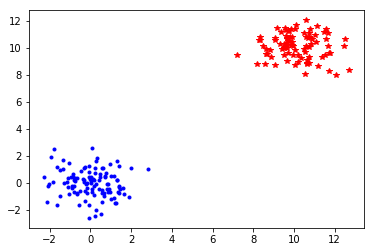

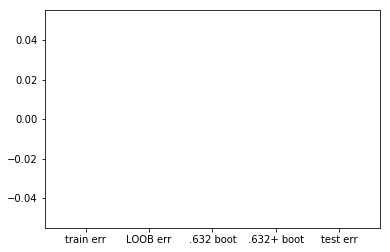

In [41]:
# main file
p_y=0.5
t_dim = 2
mu_t=[[0,0], [10,10]]
cov_mat1 = np.array([[1,0],[0,1]])
cov_mat2 = np.array([[1,0],[0,1]])
sigma_t= [cov_mat1,cov_mat2] 
length_dataset = 200
model_name = KNNModel
nb_bootstrap = 50
gaussian_dataset_booot(p_y,t_dim,mu_t, sigma_t, length_dataset,nb_bootstrap,model_name)

In [ ]:
p_y=0.5
t_dim = 2
mu_t=[[0,0], [2,2]]
cov_mat1 = np.array([[1,0],[0,1]])
cov_mat2 = np.array([[1,0],[0,1]])
sigma_t= [cov_mat1,cov_mat2] 
length_dataset = 200
model_name = LDAModel
nb_bootstrap = 50
gaussian_dataset_booot(p_y,t_dim,mu_t, sigma_t, length_dataset,nb_bootstrap,model_name)

In [ ]:
a = np.array([0,1,2])
b = np.arange(2)
print(a[b])

In [ ]:

d = LDAModel
mod = d(Gaussian_Cond_Distr_Dataset(p_y,t_dim,mu_t, sigma_t, length_dataset,seed))
print(mod)